# Merging data

This notebook contains the preprocessing pipline for cross-species cell-type annotation. 

0) Select and download relevant datasets
1) Condense similar annotation info into same obs columns
2) Map gene variables to homologus gene variables
3) QC + Basic Filtering
4) Normalization + log1p
5) Select HVGs
6) Subset each dataset.var by only shared genes by at least 2 species
7) Merge datasets (outer merge to conserve obs-metadata, fill NaN with 0)

Available kernel & conda env: `scanpy-env`


In [1]:
import os
import glob
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
# Revision number (change every time you run it again)
rev_n = 7

## Mouse Dataset

Tasic, B., Menon, V., Nguyen, T. N., Kim, T. K., Jarsky, T., Yao, Z., Levi, B., Gray, L. T., Sorensen, S. A., Dolbeare, T., Bertagnolli, D., Goldy, J., Shapovalova, N., Parry, S., Lee, C., Smith, K., Bernard, A., Madisen, L., Sunkin, S. M., Hawrylycz, M., … Zeng, H. (2016). Adult mouse cortical cell taxonomy revealed by single cell transcriptomics. Nature neuroscience, 19(2), 335–346. https://doi.org/10.1038/nn.4216

https://figshare.com/articles/dataset/allen_brain_h5ad/20338089?file=36509385

First, we'll download the mouse brain database and upload it into the server

In [4]:
!mkdir -p /home/raquelcr/scanpy/ann_datasets

In [5]:
# must be 1.0G
!du -h /home/raquelcr/scanpy/ann_datasets/allen_brain.h5ad

978M	/home/raquelcr/scanpy/ann_datasets/allen_brain.h5ad


In [6]:
mouse_data = sc.read('/home/raquelcr/scanpy/ann_datasets/allen_brain.h5ad')

In [7]:
mouse_data.shape

(14249, 34617)

In [8]:
# Create species column
mouse_data.obs['species'] = 'mouse'

In [9]:
# Load gene otholog reference table (adapted with `gene_reference.ipynb`)
gene_reference = pd.read_csv('/home/raquelcr/scanpy/gene_reference.csv')
gene_reference.head()

,NMR gene name,gene_ids,Human gene stable ID,Human gene name,Mouse gene stable ID,Mouse gene name,Local_ID,Global_name,Global_ID
0,ZMYND10,ENSHGLG00000010267,ENSG00000004838,ZMYND10,ENSMUSG00000010044,Zmynd10,LOCAL00000000000,ZMYND10,ENSHGLG00000010267
1,AMIGO3,ENSHGLG00000010542,NaN,NaN,NaN,NaN,LOCAL00000000001,AMIGO3,ENSHGLG00000010542
2,TNFSF10,ENSHGLG00000010558,NaN,NaN,NaN,NaN,LOCAL00000000002,TNFSF10,ENSHGLG00000010558
3,ENSHGLG00000010617,ENSHGLG00000010617,NaN,NaN,NaN,NaN,LOCAL00000000003,ENSHGLG00000010617,ENSHGLG00000010617
4,NPRL2,ENSHGLG00000010655,ENSG00000114388,NPRL2,ENSMUSG00000010057,Nprl2,LOCAL00000000004,NPRL2,ENSHGLG00000010655


In [10]:
# Map mouse gene names to global names using gene_reference
mouse_gene_map = dict(zip(gene_reference['Mouse gene name'], gene_reference['Global_name']))
mouse_data.var['global_name'] = mouse_data.var_names.map(mouse_gene_map)


In [11]:
print(f"Genes with global name: {mouse_data.var['global_name'].notnull().sum()}")
print(f"Genes without global name: {mouse_data.var['global_name'].isnull().sum()}")
mouse_data.var.head(10) # Lots of genes do not have an homologus.

Genes with global name: 8938
Genes without global name: 25679


,n_cells,global_name
0610005C13Rik,334,NaN
0610006L08Rik,17,NaN
0610007P14Rik,13189,NaN
0610009B22Rik,12943,NaN
0610009E02Rik,1474,NaN
0610009L18Rik,5025,NaN
0610009O20Rik,8127,NaN
0610010B08Rik,22,NaN
0610010F05Rik,12139,NaN
0610010K14Rik,13170,C17orf49


In [12]:
print(f"{str(mouse_data.var['global_name'].notna().sum())} out of {mouse_data.var.shape[0]} genes mapped to global names.")

8938 out of 34617 genes mapped to global names.


In [13]:
print(f"There are {len(mouse_data.obs[mouse_data.obs['label']!= mouse_data.obs['subclass']])} cells where label and subclass do not match.")

There are 0 cells where label and subclass do not match.


In [14]:
mouse_annotations = pd.DataFrame(mouse_data.obs['label'].unique(), columns=['mouse_types'])
mouse_annotations.head()

,mouse_types
0,Vip
1,Lamp5
2,Sst
3,Sncg
4,Serpinf1


### Mapping mouse to human celltypes

cluster_annotation.xlsx was provided by the Linnarson Lab. It describes the cluster annotation of the whole human adult dataset
See on https://github.com/linnarsson-lab/adult-human-brain/blob/main/tables/cluster_annotation.xlsx 

#### Notes:

- Some mouse subtypes (like Meis2, Serpinf1, Sncg) don’t have a 1:1 equivalent in the human label set. They were mapped to the closest CGE/Misc categories.

- Vascular cells (Endo, Peri, VLMC, SMC) were mapped to corresponding endothelial, pericyte, fibroblast, and smooth muscle populations in human.

- Excitatory neurons (L2/3 IT, L4, L5 IT/PT, L6 IT/CT/6b) were mapped to the corresponding human excitatory classes (ULIT, DLIT, DLNP, DLCT6b, L5ET).

In [15]:
human_anot = pd.read_excel('/home/raquelcr/scanpy/ann_datasets/cluster_annotation.xlsx', )
human_anot.dropna(how='all',inplace=True)
human_anot['Cluster ID'] = [int(k) for k in human_anot['Cluster ID']]
human_anot.set_index('Cluster ID', inplace=True)
human_anot.sort_values('Number of cells', ascending=False)['Number of cells']

Cluster ID
47     124837.0
45     109325.0
44     101039.0
311     97038.0
49      84282.0
         ...   
75         70.0
29         63.0
408        45.0
314        42.0
297        34.0
Name: Number of cells, Length: 461, dtype: float64

In [16]:
## needs revision
mouse2human = {
    # Inhibitory neuron types
    "Vip": "CGE_276",          # VIP interneurons (CGE-derived)
    "Lamp5": "CGE_277",        # LAMP5 interneurons (neurogliaform, CGE)
    "Sst": "MGE_236",          # SST interneurons (MGE-derived)
    "Sncg": "CGE_278",         # SNCG-positive interneurons (CGE small subset)
    "Serpinf1": "CGE_279",     # Another CGE-related population
    "Pvalb": "MGE_239",        # Parvalbumin interneurons (MGE)

    # Non-neuronal vasculature-related
    "Endo": "VendAC_14",       # Endothelial (choose one vascular subtype)
    "Peri": "Per_21",          # Pericytes
    "SMC": "Vsmc_19",          # Smooth muscle cells
    "VLMC": "Fbl_24",          # Vascular/leptomeningeal fibroblast

    # Excitatory cortical neurons
    "L6.CT": "DLCT6b_84",      # Layer 6 corticothalamic
    "L6b": "DLCT6b_97",        # Layer 6b
    "L6.IT": "DLIT_136",       # Layer 6 intratelencephalic
    "L2.3.IT": "ULIT_120",     # Upper-layer 2/3 intratelencephalic
    "L5.PT": "L5ET_113",       # Layer 5 pyramidal tract
    "L5.IT": "ULIT_133",       # Layer 5 intratelencephalic
    "L4": "DLNP_83",           # Layer 4 excitatory (NP-like)
    "NP": "DLNP_85",           # Near-projecting (layer 5 NP subtype)
    "CR": "Misc_116",          # Cajal-Retzius cells → not well represented, put in Misc

    # Glia
    "Oligo": "Oligo_40",       # Oligodendrocytes
    "Astro": "Astro_52",       # Astrocytes
    "Macrophage": "Mono_3",    # Brain macrophages/microglia
    "Meis2": "Misc_132"        # Rare Meis2+ interneuron → map to Misc
}
mouse_data.obs['cell_type'] = mouse_data.obs['label'].map(mouse2human)
mouse_data.obs['cell_type'].value_counts()

cell_type
DLIT_136     1872
MGE_236      1741
CGE_276      1728
DLNP_83      1401
MGE_239      1337
CGE_277      1122
ULIT_120      982
DLCT6b_84     960
ULIT_133      880
L5ET_113      544
Astro_52      368
DLNP_85       362
DLCT6b_97     358
CGE_278       125
VendAC_14      94
Oligo_40       91
Fbl_24         67
Vsmc_19        55
Mono_3         51
Misc_132       45
Per_21         32
CGE_279        27
Misc_116        7
Name: count, dtype: int64

In [17]:
# Map mouse gene names to supercluster using human_anot
supercluster_map = dict(zip(human_anot['Cluster name'], human_anot['Supercluster']))
mouse_data.obs['cell_supertype'] = mouse_data.obs['cell_type'].map(supercluster_map)

mouse_data.obs

,label,sizeFactor,subclass,n_counts,species,cell_type,cell_supertype
F1S4_160108_001_A01,Vip,1.085313,Vip,1730700.0,mouse,CGE_276,CGE interneuron
F1S4_160108_001_B01,Lamp5,1.197503,Lamp5,1909605.0,mouse,CGE_277,CGE interneuron
F1S4_160108_001_C01,Lamp5,1.244751,Lamp5,1984948.0,mouse,CGE_277,CGE interneuron
F1S4_160108_001_D01,Vip,1.437020,Vip,2291552.0,mouse,CGE_276,CGE interneuron
F1S4_160108_001_E01,Lamp5,1.102096,Lamp5,1757463.0,mouse,CGE_277,CGE interneuron
...,...,...,...,...,...,...,...
FYS4_171004_104_C01,L5.PT,0.595336,L5.PT,949356.0,mouse,L5ET_113,Miscellaneous
FYS4_171004_104_D01,Sst,0.626302,Sst,998736.0,mouse,MGE_236,MGE interneuron
FYS4_171004_104_F01,L5.PT,0.628829,L5.PT,1002766.0,mouse,L5ET_113,Miscellaneous
FYS4_171004_104_G01,Sst,0.643276,Sst,1025804.0,mouse,MGE_236,MGE interneuron


In [18]:
mouse_data.obs['dissection'] = 'Visual Cortex'
mouse_data.obs['region']= 'cerebral cortex'

## Human dataset

Siletti, K., Hodge, R., Mossi Albiach, A., Lee, K. W., Ding, S.-L., Hu, L., Lönnerberg, P., Bakken, T., Casper, T., Clark, M., Dee, N., Gloe, J., Hirschstein, D., Shapovalova, N. V., Keene, C. D., Nyhus, J., Tung, H., Yanny, A. M., Arenas, E., … Linnarsson, S. (2023). **Transcriptomic diversity of cell types across the adult human brain.** Science, 382(6667), eadd7046. https://doi.org/10.1126/science.add7046

https://www.biorxiv.org/content/10.1101/2022.10.12.511898v1.full.pdf



In [19]:
# Download if it doesn't exists
if os.path.exists('/home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad')!= True:
    !wget -O /home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad 'https://storage.googleapis.com/linnarsson-lab-human/human_adult_GRCh38-3.0.0.h5ad'
else:
    print("File already exists")

File already exists


In [20]:
# must be 27G
!du -h '/home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad'

27G	/home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad


### Sampling a reference human dataset

`human_aldult_GRCh38-3.0.0.h5ad` contains the gene expresssion matrix of 3,369,219 cells and 33,538 genes. In order to use it as a reference, we can sample a subset of the whole dataset to decrease computation resources needed to perform calculation. Only a fraction of randomly selected data is considered in this analysis and 34 cells per cluster were added to improve represtability of low number of cells clusters. 

In [21]:
# Stratified sampling to ensure all clusters are represented
# Takes around 10 minutes to run
def subsample_dataset(dataset_path,random_seed=71, fraction=0.05, min_per_cluster=34, filter_by=None):
    dirname = os.path.dirname(dataset_path)
    basename = os.path.basename(dataset_path)
    subset_path = os.path.join(dirname,f"{basename.split(r'[-.]')[0]}_subset{random_seed}.h5ad")

    if os.path.exists(subset_path):
        print("Loading existing subset...")
        human_data = sc.read(subset_path)
        print(f"Sampled dataset: {human_data.shape[0]} × {human_data.shape[1]}")
        return human_data
    else:
        print("Creating new subset...")

        # Step 1. Open dataset in backed mode
        adata_backed = sc.read_h5ad(dataset_path, backed="r")
        if filter_by != None:
            if filter_by in adata_backed.obs.columns:
                adata_backed = adata_backed[adata_backed.obs[filter_by].str.contains(r'[Cc]ortex|[Hh]ippocampus|[Mm]idbrain',regex=True)]
            else: return NameError(filter_by)

        n_cells = adata_backed.n_obs
        target_size = int(n_cells * fraction)
        print(f"Original: {n_cells} cells, target {target_size}")

        # Step 2. Get cluster info
        clusters = adata_backed.obs["cluster_id"].astype(str)

        np.random.seed(random_seed)
        sampled_indices = []
        summary = []  # collect stats

        # Step 3. Stratified sampling per cluster
        for clust, idx in clusters.groupby(clusters).groups.items():
            idx = np.array(list(idx))  # indices for this cluster
            n_total = len(idx)

            # desired sample = 5% + 34, but not more than available
            n_sample = int(n_total * fraction) + min_per_cluster
            n_sample = min(n_sample, n_total)

            chosen = np.random.choice(idx, size=n_sample, replace=False)
            sampled_indices.extend(chosen)

            summary.append([clust, n_total, n_sample])

        # Step 4. Load only sampled cells into memory
        human_data = sc.read_h5ad(dataset_path)[sampled_indices, :].copy()

        print(f"Final sampled dataset: {human_data.shape[0]} × {human_data.shape[1]}")

        # Step 5. Print per-cluster summary
        df_summary = pd.DataFrame(summary, columns=["cluster_id", "total_cells", "sampled_cells"])
        df_summary["fraction_sampled"] = df_summary["sampled_cells"] / df_summary["total_cells"]
        print(df_summary.sort_values("total_cells").head(20))  # show smallest clusters
        print("...")
        print(df_summary.sort_values("total_cells", ascending=False).head(20))  # show largest clusters

        # Step 6. Save the subset
        human_data.write_h5ad(subset_path)
        print(f"Sampled dataset saved to {subset_path}")
        return human_data


In [93]:
human_data = subsample_dataset('/home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad'
                               ,random_seed=37, fraction=0.03, min_per_cluster=20, filter_by='dissection')

Creating new subset...


Original: 1902327 cells, target 57069
Final sampled dataset: 65011 × 33538
    cluster_id  total_cells  sampled_cells  fraction_sampled
430         81            1              1               1.0
387        457            1              1               1.0
35          13            1              1               1.0
386        456            1              1               1.0
380        450            1              1               1.0
375        445            1              1               1.0
309        386            1              1               1.0
323        399            1              1               1.0
259        339            1              1               1.0
311        388            1              1               1.0
266        346            1              1               1.0
250        327            1              1               1.0
225        301            1              1               1.0
228        304            1              1               1.0
249       

In [94]:
human_data.obs['region']=None
human_data.obs.loc[human_data.obs['dissection'].str.contains(r'[Cc]ortex', regex=True), 'region'] = "cerebral cortex"
human_data.obs.loc[human_data.obs['dissection'].str.contains(r'[Hh]ippocampus', regex=True), 'region'] = "hippocampus"
human_data.obs.loc[human_data.obs['dissection'].str.contains(r'[Mm]idbrain', regex=True), 'region'] = "midbrain"

In [95]:
human_data.obs[['dissection', 'region']]

,dissection,region
CellID,,
10X175_8:TGCTCCAGTTGTGTAC,Midbrain (M) - Substantia Nigra - SN,midbrain
10X182_1:AAGAACAAGCCAACCC,Cerebral cortex (Cx) - Posterior parahippocamp...,cerebral cortex
10X376_7:GAACGTTGTATCGCTA,Cerebral cortex (Cx) - Inferior temporal gyrus...,cerebral cortex
10X173_4:TGAACGTCACCAAAGG,Midbrain (M) - Inferior colliculus and nearby ...,midbrain
10X222_2:CGTTCTGCAGGAGGAG,Perirhinal cortex (area 35) (A35) - rostral su...,cerebral cortex
...,...,...
10X349_1:ACGGGTCAGAAACTGT,Cerebral cortex (Cx) - Posterior intermediate ...,cerebral cortex
10X387_6:TTTCACACACAAGGTG,Tail of Hippocampus (HiT) - Subicular cortex -...,hippocampus
10X379_5:TTCTTCCCATACAGCT,Cerebral cortex (Cx) - Caudal cingulate gyrus ...,cerebral cortex


In [96]:
# See obtained cluster representation
human_data.obs['cluster_id'] = human_data.obs['cluster_id'].astype('category')
human_data.obs.groupby('cluster_id').count()['roi'].sort_values(ascending=False)

cluster_id
47     1742
138    1725
45     1686
123    1681
129    1403
       ... 
346       1
323       1
399       1
388       1
386       1
Name: roi, Length: 449, dtype: int64

In [97]:
human_data.obs.head(2)

,Tissue,TotalUMIs,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id,donor_id,suspension_type,dissection,total_UMIs,sample_id,cluster_id,roi,region
CellID,,,,,,,,,,,,,,,,
10X175_8:TGCTCCAGTTGTGTAC,Midbrain (M) - Substantia Nigra - SN,3244,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Midbrain (M) - Substantia Nigra - SN,3244,10X175_8,0,SN,midbrain
10X182_1:AAGAACAAGCCAACCC,Cerebral cortex (Cx) - Posterior parahippocamp...,3031,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Cerebral cortex (Cx) - Posterior parahippocamp...,3031,10X182_1,0,TH-TL,cerebral cortex


In [98]:
# Map human gene names to supercluster using human_anot
cluster_map = dict(zip(human_anot.index, human_anot['Cluster name']))
human_data.obs['cell_type'] = human_data.obs['cluster_id'].map(cluster_map)
human_data.obs['cell_supertype'] = human_data.obs['cell_type'].map(supercluster_map)

human_data.obs

,Tissue,TotalUMIs,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id,donor_id,suspension_type,dissection,total_UMIs,sample_id,cluster_id,roi,region,cell_type,cell_supertype
CellID,,,,,,,,,,,,,,,,,,
10X175_8:TGCTCCAGTTGTGTAC,Midbrain (M) - Substantia Nigra - SN,3244,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Midbrain (M) - Substantia Nigra - SN,3244,10X175_8,0,SN,midbrain,Bcell_0,Miscellaneous
10X182_1:AAGAACAAGCCAACCC,Cerebral cortex (Cx) - Posterior parahippocamp...,3031,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Cerebral cortex (Cx) - Posterior parahippocamp...,3031,10X182_1,0,TH-TL,cerebral cortex,Bcell_0,Miscellaneous
10X376_7:GAACGTTGTATCGCTA,Cerebral cortex (Cx) - Inferior temporal gyrus...,1640,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000136,H19.30.001,nucleus,Cerebral cortex (Cx) - Inferior temporal gyrus...,1640,10X376_7,0,ITG,cerebral cortex,Bcell_0,Miscellaneous
10X173_4:TGAACGTCACCAAAGG,Midbrain (M) - Inferior colliculus and nearby ...,2661,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Midbrain (M) - Inferior colliculus and nearby ...,2661,10X173_4,0,IC,midbrain,Bcell_0,Miscellaneous
10X222_2:CGTTCTGCAGGAGGAG,Perirhinal cortex (area 35) (A35) - rostral su...,0,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Perirhinal cortex (area 35) (A35) - rostral su...,0,10X222_2,0,A35r,cerebral cortex,Bcell_0,Miscellaneous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X349_1:ACGGGTCAGAAACTGT,Cerebral cortex (Cx) - Posterior intermediate ...,24252,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Cerebral cortex (Cx) - Posterior intermediate ...,24252,10X349_1,99,A13,cerebral cortex,DLCT6b_99,Deep-layer corticothalamic and 6b
10X387_6:TTTCACACACAAGGTG,Tail of Hippocampus (HiT) - Subicular cortex -...,15803,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000136,H19.30.001,nucleus,Tail of Hippocampus (HiT) - Subicular cortex -...,15803,10X387_6,99,Sub,hippocampus,DLCT6b_99,Deep-layer corticothalamic and 6b
10X379_5:TTCTTCCCATACAGCT,Cerebral cortex (Cx) - Caudal cingulate gyrus ...,12675,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000136,H19.30.001,nucleus,Cerebral cortex (Cx) - Caudal cingulate gyrus ...,12675,10X379_5,99,A23,cerebral cortex,DLCT6b_99,Deep-layer corticothalamic and 6b


In [99]:
# Add species column
human_data.obs['species'] = 'human'
human_data.obs.head(2)

,Tissue,TotalUMIs,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id,donor_id,suspension_type,dissection,total_UMIs,sample_id,cluster_id,roi,region,cell_type,cell_supertype,species
CellID,,,,,,,,,,,,,,,,,,,
10X175_8:TGCTCCAGTTGTGTAC,Midbrain (M) - Substantia Nigra - SN,3244,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Midbrain (M) - Substantia Nigra - SN,3244,10X175_8,0,SN,midbrain,Bcell_0,Miscellaneous,human
10X182_1:AAGAACAAGCCAACCC,Cerebral cortex (Cx) - Posterior parahippocamp...,3031,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Cerebral cortex (Cx) - Posterior parahippocamp...,3031,10X182_1,0,TH-TL,cerebral cortex,Bcell_0,Miscellaneous,human


In [100]:
human_data.var_names

Index(['ENSG00000237613', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000284733', 'ENSG00000284662',
       'ENSG00000225880', 'ENSG00000230368', 'ENSG00000223764',
       'ENSG00000188976',
       ...
       'ENSG00000228240', 'ENSG00000226906', 'ENSG00000183753',
       'ENSG00000205944', 'ENSG00000227439', 'ENSG00000235412',
       'ENSG00000183795', 'ENSG00000205916', 'ENSG00000172288',
       'ENSG00000231141'],
      dtype='object', name='Accession', length=33538)

In [101]:
# Map human gene names to global names using gene_reference
human_gene_map = dict(zip(gene_reference['Human gene stable ID'], gene_reference['Global_name']))
human_data.var['global_name'] = human_data.var_names.map(human_gene_map)


In [102]:
print(f"{str(human_data.var['global_name'].notna().sum())} out of {human_data.var.shape[0]} genes mapped to global names.")

8497 out of 33538 genes mapped to global names.


In [103]:
human_data.var[12:20]

,Chromosome,End,Gene,Start,Strand,global_name
Accession,,,,,,
ENSG00000188290,1,1000172,HES4,998962,-,NaN
ENSG00000224969,1,1013193,AL645608.2,1011997,-,NaN
ENSG00000273443,1,1063288,AL645608.9,1062208,-,NaN
ENSG00000237330,1,1074307,RNF223,1070966,-,RNF223
ENSG00000131591,1,1116361,C1orf159,1081818,-,C1orf159
ENSG00000205231,1,1179555,TTLL10-AS1,1173056,-,NaN
ENSG00000186891,1,1206691,TNFRSF18,1203508,-,TNFRSF18
ENSG00000186827,1,1214138,TNFRSF4,1211326,-,TNFRSF4


In [104]:
human_data.shape

(65011, 33538)

## Developing Human Brain

This dataset contains 1,665,937 cells, so it is recommended to subsample it.

Eze, U.C., Bhaduri, A., Haeussler, M. et al. Single-cell atlas of early human brain development highlights heterogeneity of human neuroepithelial cells and early radial glia. Nat Neurosci 24, 584–594 (2021). https://doi.org/10.1038/s41593-020-00794-1

https://assets.nemoarchive.org/dat-0rsydy7

File: scanpy/ann_datasets/human_dev.h5ad (Must be 12GB)


In [34]:
!du -h /home/raquelcr/scanpy/ann_datasets/human_dev.h5ad

12G	/home/raquelcr/scanpy/ann_datasets/human_dev.h5ad


In [105]:
dev_human = subsample_dataset('/home/raquelcr/scanpy/ann_datasets/human_dev.h5ad'
                               ,random_seed=37, fraction=0.05, min_per_cluster=20, filter_by='Region')

Creating new subset...
Original: 256434 cells, target 12821
Final sampled dataset: 19981 × 59459
    cluster_id  total_cells  sampled_cells  fraction_sampled
1            1            1              1               1.0
418        604            1              1               1.0
424         61            1              1               1.0
420        606            1              1               1.0
45         139            1              1               1.0
431        616            1              1               1.0
61         153            1              1               1.0
413          6            1              1               1.0
398        577            1              1               1.0
89         201            1              1               1.0
116         23            1              1               1.0
115        228            1              1               1.0
78         181            1              1               1.0
76         168            1              1       

In [106]:
# Add species column
dev_human.obs['species'] = 'human'
dev_human.obs['region'] = None
dev_human.obs.loc[dev_human.obs['Region'].str.contains(r'[Cc]ortex', regex=True), 'region'] = "cerebral cortex"
dev_human.obs.loc[dev_human.obs['Region'].str.contains(r'[Hh]ippocampus', regex=True), 'region'] = "hippocampus"
dev_human.obs.loc[dev_human.obs['Region'].str.contains(r'[Mm]idbrain', regex=True), 'region'] = "midbrain"
dev_human.obs.head(4)

,Age,CellClass,Chemistry,Region,Subregion,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,...,cell_type_ontology_term_id,fraction_mitochondrial,fraction_unspliced,cell_cycle_score,total_genes,total_UMIs,sample_id,cluster_id,species,region
CellID,,,,,,,,,,,,,,,,,,,,,
10X122_8:TTATGCTAGGTGCAAC,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,CL:0000031,0.003380,0.349109,0.002459,1797,3254,10X122_8,0,human,midbrain
10X122_7:TCTTCGGAGGTTACCT,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,CL:0000031,0.008454,0.315048,0.007139,2624,5323,10X122_7,0,human,midbrain
10X122_7:ACCCACTAGAAGATTC,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,CL:0000031,0.016073,0.295672,0.002228,2820,6284,10X122_7,0,human,midbrain
10X122_7:CCCAGTTCAGCGTTCG,6.9,Radial glia,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,CL:0000681,0.016281,0.288108,0.003067,2314,4238,10X122_7,1,human,midbrain


In [107]:
dev2humananot = {
    # Células del Linaje Neuronal
    "Neuroblast": "DLNP_83",  # Neuroblastos son progenitores neuronales. DLNP (Deep Layer Neuronal Progenitor) es un buen representante.
    "Neuronal IPC": "DLIT_136",  # IPC (Intermediate Progenitor Cell). DLIT (Deep Layer Inhibitory Neuron) como un destino específico de un IPC neuronal.
    "Neuron": "L5ET_113",  # Neurona. L5ET (Layer 5 Excitatory Neuron) es un tipo principal de neurona cortical.

    # Células Gliales y Progenitoras
    "Radial glia": "Bgl_51",  # Glía Radial. Bgl (Bergmann Glia) es un tipo de glía radial en el cerebelo, o podemos usar Astro_52 como un subtipo diferenciado (los astrocitos son descendientes de la glía radial).
    "Glioblast": "Astro_52",  # Glioblastos son progenitores gliales, que dan lugar a astrocitos y oligodendrocitos. Astro_52 (Astrocito) es un linaje directo.
    "Oligo": "Oligo_40",  # Oligodendrocito. Oligo_40 es un subtipo de oligodendrocito maduro.

    # Células Inmunes
    "Immune": "Mgl_4",  # Inmune. Mgl (Microglia) es el principal tipo de célula inmune residente del SNC.

    # Células Vasculares y Asociadas
    "Vascular": "VendPLVAP_13",  # Vascular. Vend (Vascular Endothelial cell), la célula endotelial vascular con un marcador específico (PLVAP).

    # Células de Soporte No Neuronales / No Gliales
    "Fibroblast": "Fbl_24",  # Fibroblasto. Fbl (Fibroblast) con una especificación de subtipo.
    "Erythrocyte": "Misc_116",  # Eritrocito. A menudo agrupados en células "Misceláneas" o "Hematopoyéticas" en scRNA-seq de cerebro, ya que no son residentes.

    # Linajes Embrionarios
    "Neural crest": "Per_21",  # Cresta Neural. Algunas células de la cresta neural migran al SNC y dan lugar a Pericitos (Per), que son células murales vasculares.
    "Placodes": "Chrp_76"  # Placodes. Chrp (Choroid Plexus) son epitelios especializados con orígenes neuroectodermales, que podrían ser un representante funcional en un conjunto de datos adulto/desarrollo tardío.
}

In [108]:
dev_human.obs['cell_type'] = dev_human.obs['CellClass'].map(dev2humananot)
dev_human.obs['cell_supertype'] = dev_human.obs['cell_type'].map(supercluster_map)

dev_human.obs

,Age,CellClass,Chemistry,Region,Subregion,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,...,fraction_unspliced,cell_cycle_score,total_genes,total_UMIs,sample_id,cluster_id,species,region,cell_type,cell_supertype
CellID,,,,,,,,,,,,,,,,,,,,,
10X122_8:TTATGCTAGGTGCAAC,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.349109,0.002459,1797,3254,10X122_8,0,human,midbrain,DLNP_83,Deep-layer near-projecting
10X122_7:TCTTCGGAGGTTACCT,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.315048,0.007139,2624,5323,10X122_7,0,human,midbrain,DLNP_83,Deep-layer near-projecting
10X122_7:ACCCACTAGAAGATTC,6.9,Neuroblast,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.295672,0.002228,2820,6284,10X122_7,0,human,midbrain,DLNP_83,Deep-layer near-projecting
10X122_7:CCCAGTTCAGCGTTCG,6.9,Radial glia,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.288108,0.003067,2314,4238,10X122_7,1,human,midbrain,Bgl_51,Bergmann glia
10X185_4:TCCCAGTGTCCAATCA,12.0,Glioblast,v3,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,unknown,...,0.309786,0.003602,2339,4997,10X185_4,10,human,midbrain,Astro_52,Astrocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X89_7:CTACACCAGATGTTAG,8.0,Radial glia,v2,Midbrain,Midbrain ventral,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.146667,0.002151,1426,2325,10X89_7,99,human,midbrain,Bgl_51,Bergmann glia
10X122_8:AGACGTTGTTTCGCTC,6.9,Radial glia,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.241007,0.030991,2007,3614,10X122_8,99,human,midbrain,Bgl_51,Bergmann glia
10X122_8:GCTGCTTAGAATGTTG,6.9,Radial glia,v2,Midbrain,Midbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.290955,0.003822,2102,3925,10X122_8,99,human,midbrain,Bgl_51,Bergmann glia


In [109]:
# Find mito_genes
dev_human.var['mt'] = dev_human.var['Gene'].str.startswith('MT-')
print(f'Found {str(dev_human.var["mt"].sum())} mito genes')

Found 37 mito genes


In [110]:
gene_reference.head(2)

,NMR gene name,gene_ids,Human gene stable ID,Human gene name,Mouse gene stable ID,Mouse gene name,Local_ID,Global_name,Global_ID
0,ZMYND10,ENSHGLG00000010267,ENSG00000004838,ZMYND10,ENSMUSG00000010044,Zmynd10,LOCAL00000000000,ZMYND10,ENSHGLG00000010267
1,AMIGO3,ENSHGLG00000010542,NaN,NaN,NaN,NaN,LOCAL00000000001,AMIGO3,ENSHGLG00000010542


In [111]:
# Drop last part of the Accession to match gene_reference 
dev_human.var['Accession'] = [acc.split('.')[0] if pd.notna(acc) else acc for acc in dev_human.var['Accession']]
dev_human.var

,Accession,Chromosome,End,GeneTotalUMIs,Start,Gene,mt
Accession,,,,,,,
ENSG00000223972.5,ENSG00000223972,chr1,14409,3,11869,DDX11L1,False
ENSG00000227232.5,ENSG00000227232,chr1,29570,104073,14404,WASH7P,False
ENSG00000278267.1,ENSG00000278267,chr1,17436,0,17369,MIR6859-1,False
ENSG00000284332.1,ENSG00000284332,chr1,30503,0,30366,MIR1302-2,False
ENSG00000268020.3,ENSG00000268020,chr1,53312,0,52473,OR4G4P,False
...,...,...,...,...,...,...,...
ENSG00000275757.1,ENSG00000275757,chr22_KI270733v1,174108,0,173956,5_8S_rRNA-8,False
ENSG00000278573.1,ENSG00000278573,chr22_KI270734v1,60316,0,59711,AC007325.3,False
ENSG00000276017.1,ENSG00000276017,chr22_KI270734v1,74814,15,72411,AC007325.1,False


In [112]:
dev_human.var['global_name'] = dev_human.var['Accession'].map(human_gene_map)
dev_human.var['global_name'].notnull().sum() # must not be 0 or near 0

np.int64(8507)

In [113]:
dev_human.var_names = dev_human.var['global_name']
dev_human.var.sort_values('GeneTotalUMIs', ascending=False).head(15)

,Accession,Chromosome,End,GeneTotalUMIs,Start,Gene,mt,global_name
global_name,,,,,,,,
NaN,ENSG00000251562,chr11,65506516,419535869,65497688,MALAT1,False,NaN
Tuba1a,ENSG00000167552,chr12,49189080,82872215,49184795,TUBA1A,False,Tuba1a
NaN,ENSG00000210082,chrM,3229,54470313,1671,MT-RNR2,True,NaN
COX1,ENSG00000198804,chrM,7445,50031188,5904,MT-CO1,True,COX1
NaN,ENSG00000147403,chrX,154409168,47190036,154389955,RPL10,False,NaN
ACTG1,ENSG00000184009,chr17,81523847,46167199,81509971,ACTG1,False,ACTG1
NaN,ENSG00000034510,chr2,84906671,45385699,84905656,TMSB10,False,NaN
NaN,ENSG00000205542,chrX,12977227,45256038,12975110,TMSB4X,False,NaN
COX3,ENSG00000198938,chrM,9990,45054217,9207,MT-CO3,True,COX3


In [114]:
# drop genes without global name
dev_human = dev_human[:, dev_human.var['global_name'].notna()].copy()
dev_human.var_names_make_unique()

In [115]:
dev_human

AnnData object with n_obs × n_vars = 19981 × 8507
    obs: 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'dissection', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'species', 'region', 'cell_type', 'cell_supertype'
    var: 'Accession', 'Chromosome', 'End', 'GeneTotalUMIs', 'Start', 'Gene', 'mt', 'global_name'
    uns: 'batch_condition', 'title'
    obsm: 'Factors', 'X_Embedding'
    varm: 'Loadings'

## Naked Mole Rat Datasets

In [ ]:
nmr_files = glob.glob('/home/raquelcr/scanpy/cellbender/denoised/*_filtered.h5')
nmr_files

['/home/raquelcr/scanpy/cellbender/denoised/NMR2_cerebral_cortex_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR1_cerebral_cortex_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR3_hippocampus_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR4_hippocampus_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR5_midbrain_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR6_midbrain_denoised_filtered.h5']

In [117]:
gene_reference

,NMR gene name,gene_ids,Human gene stable ID,Human gene name,Mouse gene stable ID,Mouse gene name,Local_ID,Global_name,Global_ID
0,ZMYND10,ENSHGLG00000010267,ENSG00000004838,ZMYND10,ENSMUSG00000010044,Zmynd10,LOCAL00000000000,ZMYND10,ENSHGLG00000010267
1,AMIGO3,ENSHGLG00000010542,NaN,NaN,NaN,NaN,LOCAL00000000001,AMIGO3,ENSHGLG00000010542
2,TNFSF10,ENSHGLG00000010558,NaN,NaN,NaN,NaN,LOCAL00000000002,TNFSF10,ENSHGLG00000010558
3,ENSHGLG00000010617,ENSHGLG00000010617,NaN,NaN,NaN,NaN,LOCAL00000000003,ENSHGLG00000010617,ENSHGLG00000010617
4,NPRL2,ENSHGLG00000010655,ENSG00000114388,NPRL2,ENSMUSG00000010057,Nprl2,LOCAL00000000004,NPRL2,ENSHGLG00000010655
...,...,...,...,...,...,...,...,...,...
20769,ENSHGLG00000000459,ENSHGLG00000000459,NaN,NaN,NaN,NaN,LOCAL00000020769,ENSHGLG00000000459,ENSHGLG00000000459
20770,ENSHGLG00000000069,ENSHGLG00000000069,NaN,NaN,NaN,NaN,LOCAL00000020770,ENSHGLG00000000069,ENSHGLG00000000069
20771,ENSHGLG00000019630,ENSHGLG00000019630,NaN,NaN,NaN,NaN,LOCAL00000020771,ENSHGLG00000019630,ENSHGLG00000019630
20772,ENSHGLG00000019772,ENSHGLG00000019772,NaN,NaN,NaN,NaN,LOCAL00000020772,ENSHGLG00000019772,ENSHGLG00000019772


In [118]:
nmr_adatas = []
nmr_gene_map = dict(zip(gene_reference['NMR gene name'], gene_reference['Global_name']))

for file in nmr_files:
    # CellBender output should be read with read_10x_h5
    try: 
        adata = sc.read_10x_h5(file)
    except:
        adata = sc.read(file)

    adata.var['species'] = 'nmr'

    sample = file.replace('/home/raquelcr/scanpy/cellbender/denoised/NMR', '').replace('_denoised_filtered.h5', '').split('_', 1)
    sample_id = sample[0]
    tissue = sample[1]

    print(f'Loading sample {sample_id} of {tissue}')

    adata.obs['species'] = 'nmr'
    adata.obs['tissue'] = tissue
    adata.obs['sample_id'] = sample_id
    adata.obs['replicate'] = (int(sample_id)+1)%2+1

    # Map NMR gene IDs to global names
    adata.var['global_name'] = adata.var_names.map(nmr_gene_map)
    
    nmr_adatas.append(adata)

nmr_adatas

Loading sample 2 of cerebral_cortex
Loading sample 1 of cerebral_cortex
Loading sample 3 of hippocampus
Loading sample 4 of hippocampus
Loading sample 5 of midbrain
Loading sample 6 of midbrain


[AnnData object with n_obs × n_vars = 19487 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'global_name',
 AnnData object with n_obs × n_vars = 14268 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'global_name',
 AnnData object with n_obs × n_vars = 6743 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'global_name',
 AnnData object with n_obs × n_vars = 8179 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'global_name',
 AnnData object with n_obs × n_vars = 7369 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'global_name',
 AnnData object with n_obs × n_vars = 10080 × 20774
     obs: 'species', 'tissue', 'samp

In [119]:
nmr_adatas[0].var

,gene_ids,feature_types,genome,species,global_name
ZMYND10,ENSHGLG00000010267,Gene Expression,NA,nmr,ZMYND10
AMIGO3,ENSHGLG00000010542,Gene Expression,NA,nmr,AMIGO3
TNFSF10,ENSHGLG00000010558,Gene Expression,NA,nmr,TNFSF10
ENSHGLG00000010617,ENSHGLG00000010617,Gene Expression,NA,nmr,ENSHGLG00000010617
NPRL2,ENSHGLG00000010655,Gene Expression,NA,nmr,NPRL2
...,...,...,...,...,...
ENSHGLG00000000459,ENSHGLG00000000459,Gene Expression,NA,nmr,ENSHGLG00000000459
ENSHGLG00000000069,ENSHGLG00000000069,Gene Expression,NA,nmr,ENSHGLG00000000069
ENSHGLG00000019630,ENSHGLG00000019630,Gene Expression,NA,nmr,ENSHGLG00000019630
ENSHGLG00000019772,ENSHGLG00000019772,Gene Expression,NA,nmr,ENSHGLG00000019772


In [120]:
nmr_data = sc.concat(nmr_adatas,axis=0, join='outer', label='sample', keys=[os.path.basename(f).replace('_denoised_filtered.h5', '').split('_',1)[0] for f in nmr_files], index_unique='-')
nmr_data.shape

(66126, 20774)

In [121]:
nmr_data.obs['region'] = None
nmr_data.obs.loc[nmr_data.obs['tissue'].str.contains(r'[Cc]ortex', regex=True), 'region'] = "cerebral cortex"
nmr_data.obs.loc[nmr_data.obs['tissue'].str.contains(r'[Hh]ippocampus', regex=True), 'region'] = "hippocampus"
nmr_data.obs.loc[nmr_data.obs['tissue'].str.contains(r'[Mm]idbrain', regex=True), 'region'] = "midbrain"
nmr_data.obs.head(4)

,species,tissue,sample_id,replicate,sample,region
TCGCTTGGTCATCCCT-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex
AACAACCCACAAGCCC-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex
ACGTACAGTGATGGCA-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex
TTCCACGAGCACCGTC-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex


In [122]:
nmr_data.var['gene_ids'] = nmr_data.var_names.map(dict(zip(gene_reference['NMR gene name'], gene_reference['gene_ids'])))
nmr_data.var['genome'] = adata.var['genome'][0]
nmr_data.var['feature_types'] = adata.var['feature_types'][0]
nmr_data.var['species'] = 'nmr'
nmr_data.var['global_name'] = nmr_data.var_names.map(nmr_gene_map)


In [123]:
nmr_data.var

,gene_ids,genome,feature_types,species,global_name
ZMYND10,ENSHGLG00000010267,NA,Gene Expression,nmr,ZMYND10
AMIGO3,ENSHGLG00000010542,NA,Gene Expression,nmr,AMIGO3
TNFSF10,ENSHGLG00000010558,NA,Gene Expression,nmr,TNFSF10
ENSHGLG00000010617,ENSHGLG00000010617,NA,Gene Expression,nmr,ENSHGLG00000010617
NPRL2,ENSHGLG00000010655,NA,Gene Expression,nmr,NPRL2
...,...,...,...,...,...
ENSHGLG00000000459,ENSHGLG00000000459,NA,Gene Expression,nmr,ENSHGLG00000000459
ENSHGLG00000000069,ENSHGLG00000000069,NA,Gene Expression,nmr,ENSHGLG00000000069
ENSHGLG00000019630,ENSHGLG00000019630,NA,Gene Expression,nmr,ENSHGLG00000019630
ENSHGLG00000019772,ENSHGLG00000019772,NA,Gene Expression,nmr,ENSHGLG00000019772


## Check individual QC metrics

In [124]:
nmr_mito_genes = open('/home/raquelcr/scanpy/nmr_mito_genes.txt', 'r').read().splitlines()
nmr_mito_genes

['ND1',
 'ND2',
 'COX1',
 'COX2',
 'ATP8',
 'ATP6',
 'COX3',
 'ND3',
 'ND4L',
 'ND4',
 'ND5',
 'ND6',
 'CYTB']

In [125]:
human_ribo_genes = pd.read_csv('/home/raquelcr/scanpy/human_ribo_genes.csv', header=1)
human_ribo_genes = human_ribo_genes['Approved symbol'].tolist()
len(human_ribo_genes)

247

In [126]:
for adata in [mouse_data,human_data,nmr_data, dev_human]:
    print(adata.obs['species'][0])
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    if 'mt' not in nmr_data.var.columns:
        try: adata.var["mt"] = adata.var['Chromosome'] == 'MT'
        except: adata.var["mt"] = adata.var_names.str.startswith(("mt-", "MT-","Mt-")) |[gene in nmr_mito_genes for gene in adata.var_names]
    print(f'Found {adata.var["mt"].sum()} mito genes.')
    # ribosomal genes
    try: adata.var["ribo"] = [name in human_ribo_genes for name in adata.var['Gene']]
    except: adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL", "Rpl", "Rps"))
    print(f'Found {adata.var["ribo"].sum()} ribo genes.\n')
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True)

mouse
Found 13 mito genes.
Found 367 ribo genes.

human
Found 13 mito genes.
Found 171 ribo genes.

nmr
Found 13 mito genes.
Found 78 ribo genes.

human
Found 8 mito genes.
Found 43 ribo genes.



mouse


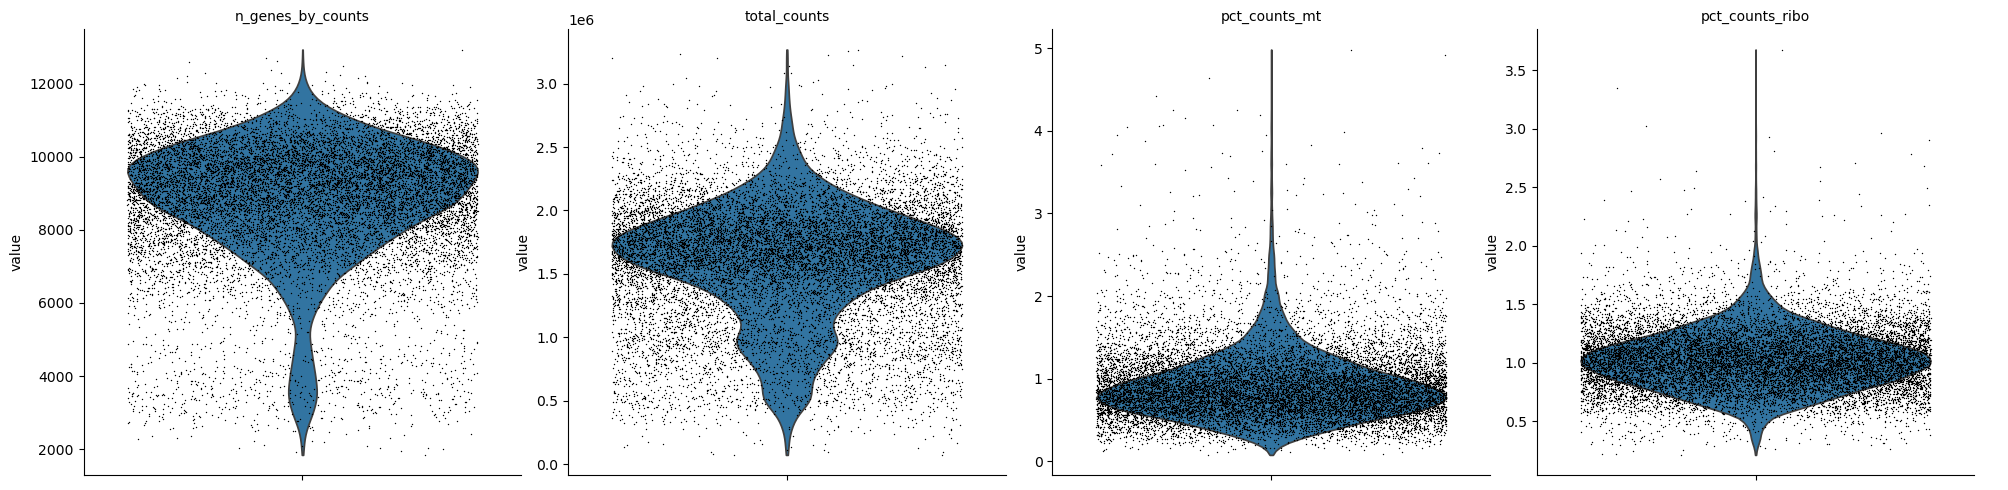

human


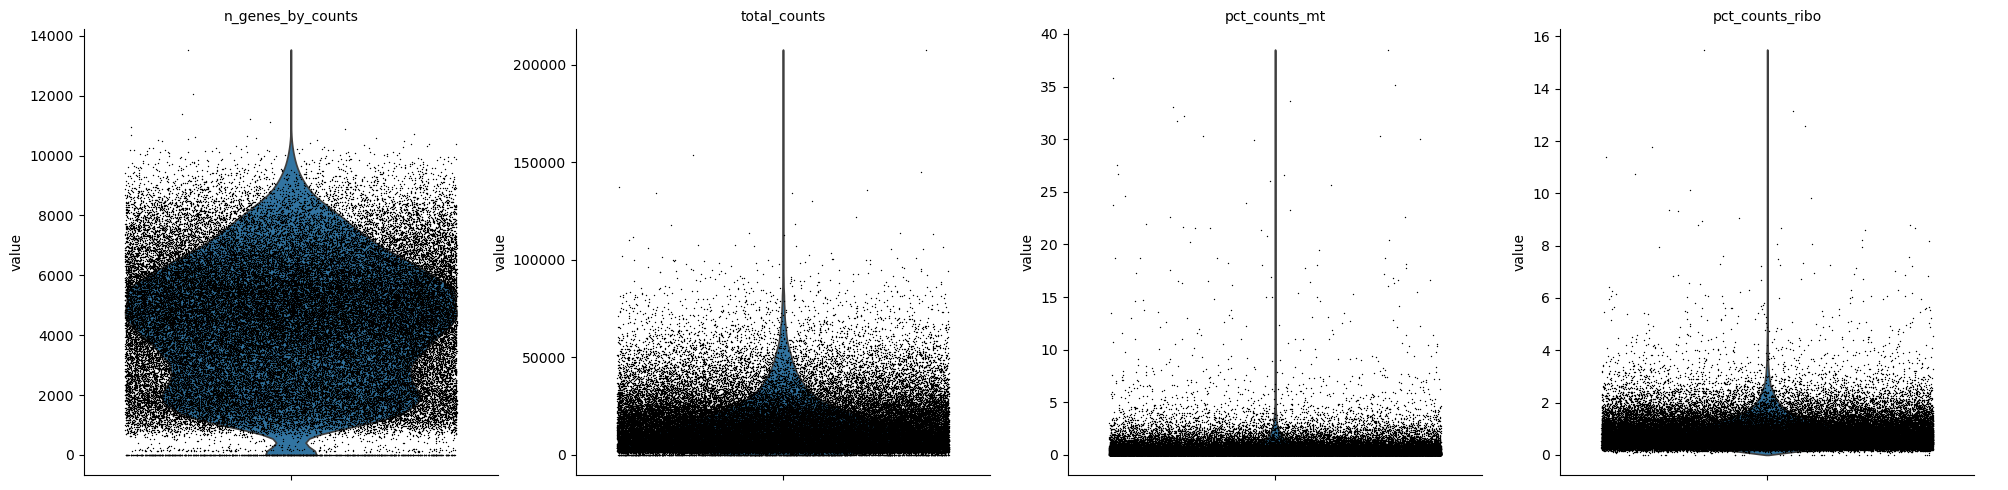

nmr


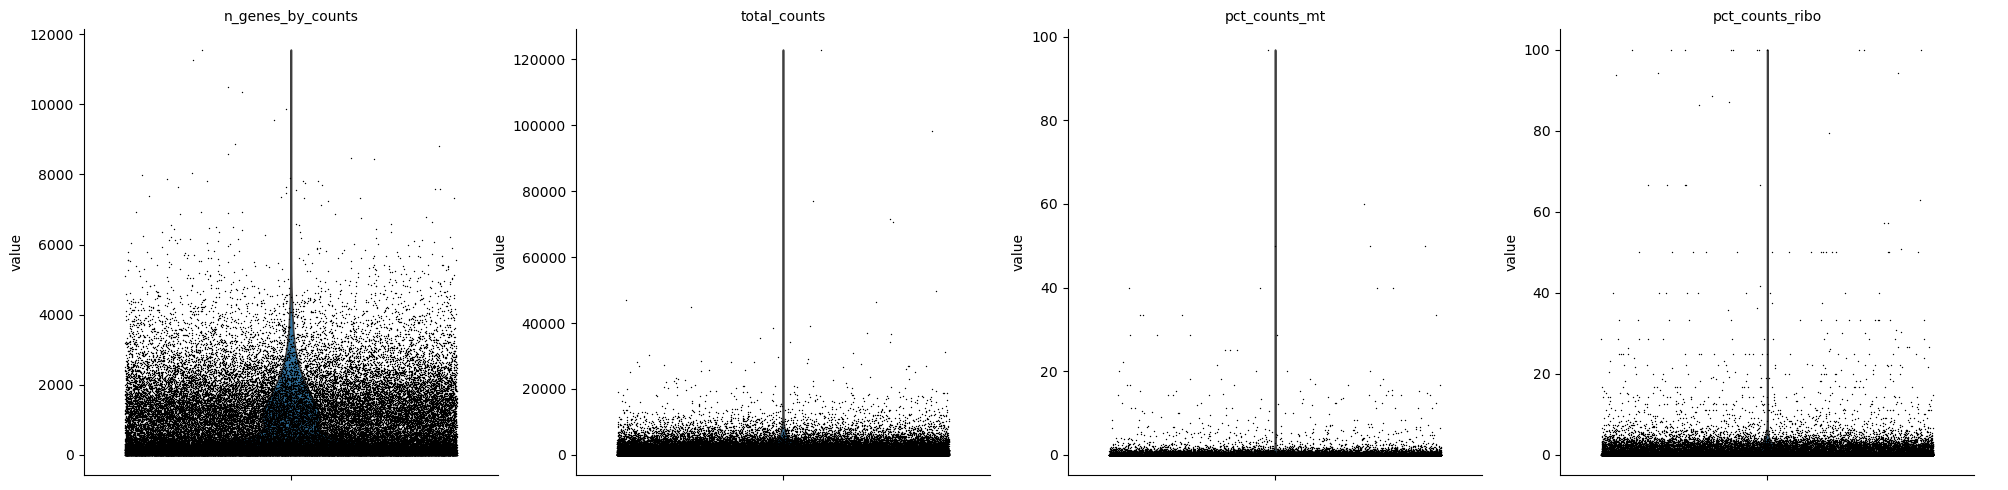

human


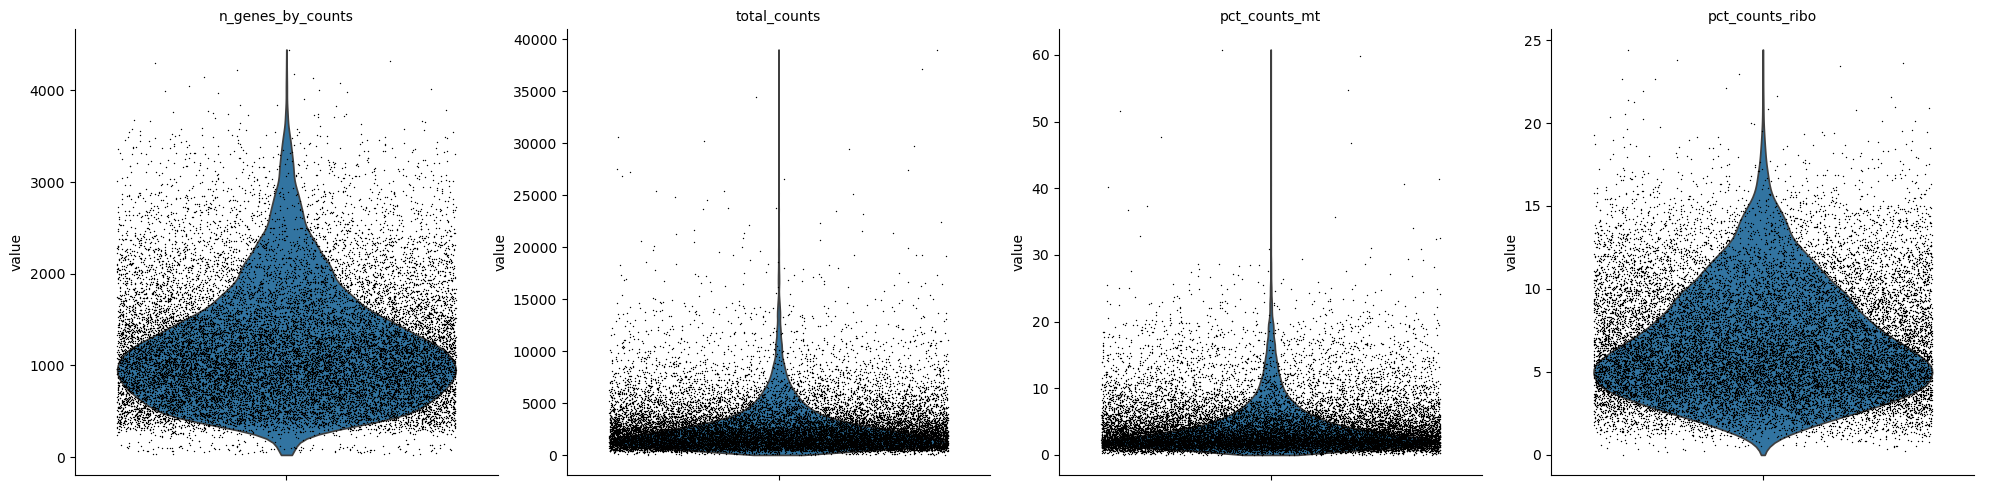

In [127]:
for adata in [mouse_data,human_data,nmr_data, dev_human]:
    print(adata.obs['species'][0])
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
        jitter=0.4,
        multi_panel=True,
    )

In [128]:
nmr_data.obs

,species,tissue,sample_id,replicate,sample,region,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo
TCGCTTGGTCATCCCT-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex,8820,9.084891,44836.0,10.710789,7.801766,12.142029,18.491837,31.813721,46.0,3.850148,0.102596,378.0,5.937536,0.843073
AACAACCCACAAGCCC-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex,7324,8.899048,28299.0,10.250617,9.138132,14.095904,21.032545,34.683204,16.0,2.833213,0.056539,142.0,4.962845,0.501785
ACGTACAGTGATGGCA-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex,7688,8.947546,27593.0,10.225354,8.353568,12.861958,19.472330,32.432139,35.0,3.583519,0.126844,220.0,5.398163,0.797304
TTCCACGAGCACCGTC-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex,7574,8.932609,27076.0,10.206440,8.151130,12.483380,19.005762,32.024671,28.0,3.367296,0.103413,253.0,5.537334,0.934407
CAGATACGTATTGGCT-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,cerebral cortex,6932,8.844048,25839.0,10.159679,12.097991,17.713534,24.946786,38.314176,25.0,3.258097,0.096753,135.0,4.912655,0.522466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATTCTACATAGTCGT-1-NMR6,nmr,midbrain,6,2,NMR6,midbrain,5,1.791759,31.0,3.465736,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
GACATCATCATGAGTC-1-NMR6,nmr,midbrain,6,2,NMR6,midbrain,3,1.386294,24.0,3.218876,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
TTGTGGATCTGGGCGT-1-NMR6,nmr,midbrain,6,2,NMR6,midbrain,1,0.693147,27.0,3.332205,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
TGGTACATCCGGACGT-1-NMR6,nmr,midbrain,6,2,NMR6,midbrain,6,1.945910,26.0,3.295837,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [129]:
# See cells that will be droped out by a basic filtering
print('n_genes_by_counts <= 30:\n',nmr_data.obs[nmr_data.obs['n_genes_by_counts']<=30].value_counts('sample'))
print('\nlog1p_total_counts <= 4:\n',nmr_data.obs[nmr_data.obs['log1p_total_counts']<=4].value_counts('sample'))
print('\nlog1p_total_counts > 10:\n',nmr_data.obs[nmr_data.obs['log1p_total_counts']>10].value_counts('sample'))
print('\npct_counts_mt > 5 :\n',nmr_data.obs[nmr_data.obs['pct_counts_mt']>5].value_counts('sample'))
print('\npct_counts_ribo > 7 :\n',nmr_data.obs[nmr_data.obs['pct_counts_ribo']>7].value_counts('sample'))



n_genes_by_counts <= 30:
 sample
NMR6    5298
NMR5    2342
NMR2     107
NMR3      63
NMR1       0
NMR4       0
Name: count, dtype: int64

log1p_total_counts <= 4:
 sample
NMR6    5636
NMR5    2816
NMR2     204
NMR3      77
NMR1       0
NMR4       0
Name: count, dtype: int64

log1p_total_counts > 10:
 sample
NMR3    30
NMR4     9
NMR2     8
NMR1     1
NMR5     0
NMR6     0
Name: count, dtype: int64

pct_counts_mt > 5 :
 sample
NMR5    112
NMR6     68
NMR1      3
NMR2      2
NMR3      2
NMR4      1
Name: count, dtype: int64

pct_counts_ribo > 7 :
 sample
NMR6    331
NMR5    318
NMR1      3
NMR4      2
NMR2      1
NMR3      1
Name: count, dtype: int64


In [130]:
print('\nlog1p_total_counts > 15:\n',mouse_data.obs[mouse_data.obs['log1p_total_counts']>15].value_counts('cell_supertype'))



log1p_total_counts > 15:
 cell_supertype
Astrocyte                            0
CGE interneuron                      0
Deep-layer corticothalamic and 6b    0
Deep-layer intratelencephalic        0
Deep-layer near-projecting           0
Fibroblast                           0
MGE interneuron                      0
Miscellaneous                        0
Oligodendrocyte                      0
Upper-layer intratelencephalic       0
Vascular                             0
Name: count, dtype: int64


In [131]:
# Filter out low-quality cells in mouse data
mouse_data = mouse_data[mouse_data.obs['log1p_total_counts'] < 15,:]
mouse_data = mouse_data[mouse_data.obs['pct_counts_mt'] < 5,:]
mouse_data = mouse_data[mouse_data.obs['pct_counts_ribo'] < 7,:]
mouse_data.shape

(14181, 34617)

In [132]:
# Filter out low-quality cells in human data
human_data = human_data[human_data.obs['log1p_total_counts'] > 4,:]
human_data = human_data[human_data.obs['log1p_total_counts'] < 10,:]
human_data = human_data[human_data.obs['pct_counts_mt'] < 5,:]
human_data = human_data[human_data.obs['pct_counts_ribo'] < 7,:]
human_data.shape

(48406, 33538)

In [133]:
# Filter out low-quality cells in nmr data
nmr_data = nmr_data[nmr_data.obs['log1p_total_counts'] > 4,:]
nmr_data = nmr_data[nmr_data.obs['log1p_total_counts'] < 10,:]
nmr_data = nmr_data[nmr_data.obs['pct_counts_mt'] < 3,:]
nmr_data = nmr_data[nmr_data.obs['pct_counts_ribo'] < 7,:]
nmr_data.shape

(57171, 20774)

In [134]:
# Filter out low-quality cells in human dev data
dev_human = dev_human[dev_human.obs['log1p_total_counts'] > 4,:]
dev_human = dev_human[dev_human.obs['log1p_total_counts'] < 10,:]
dev_human = dev_human[dev_human.obs['pct_counts_mt'] < 5,:]
dev_human = dev_human[dev_human.obs['pct_counts_ribo'] < 7,:]
dev_human.shape

(8703, 8507)

mouse


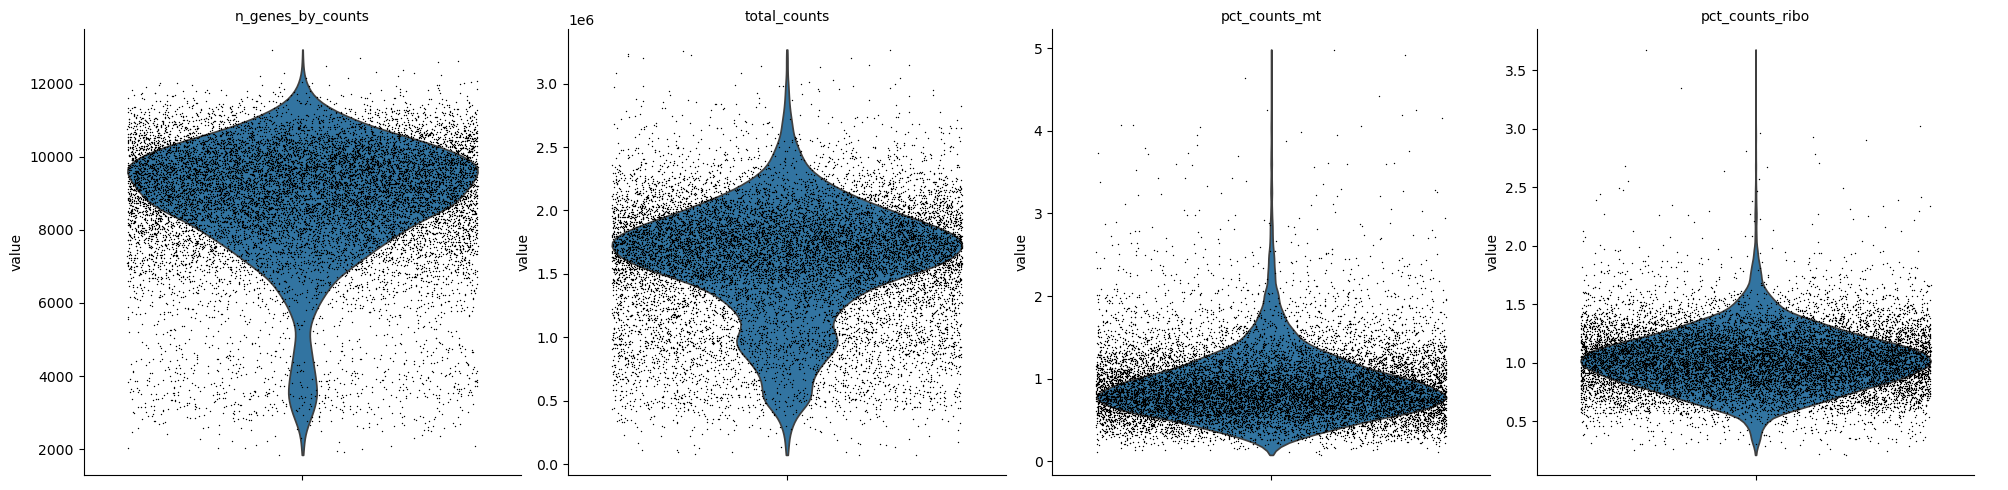

human


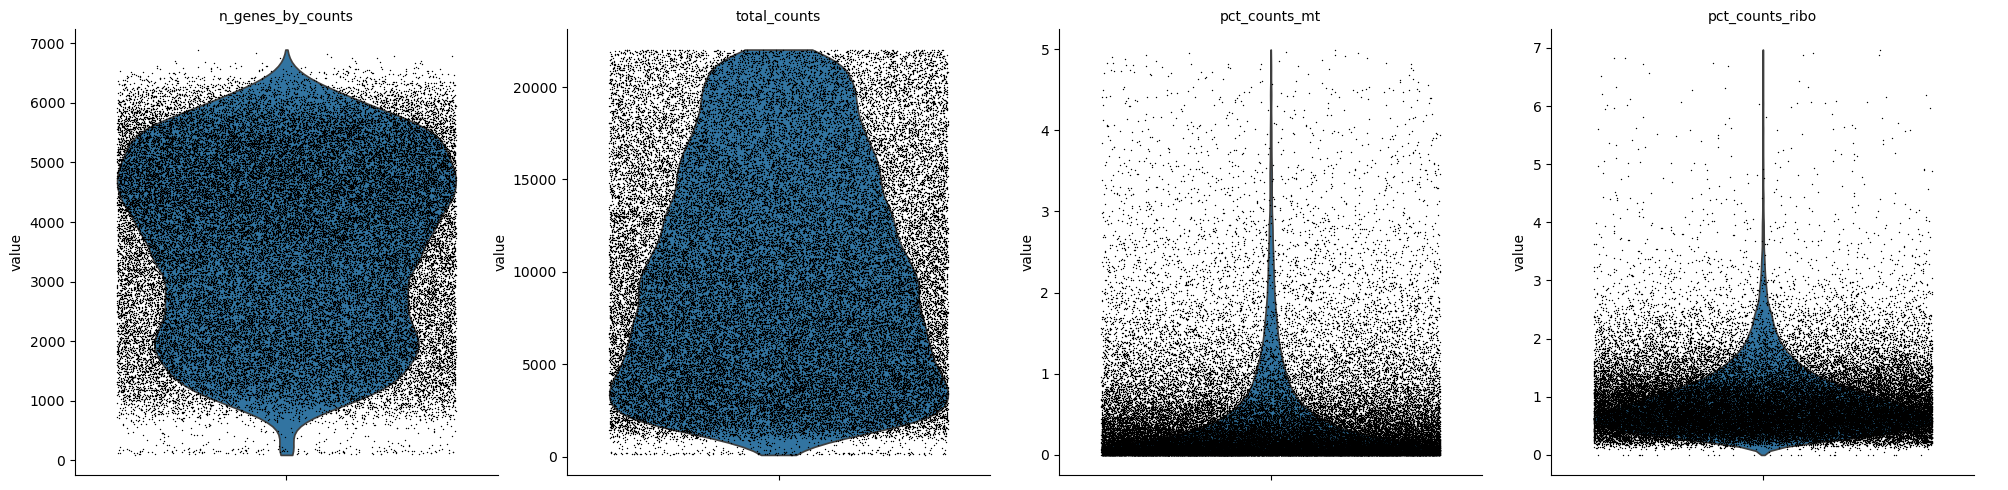

nmr


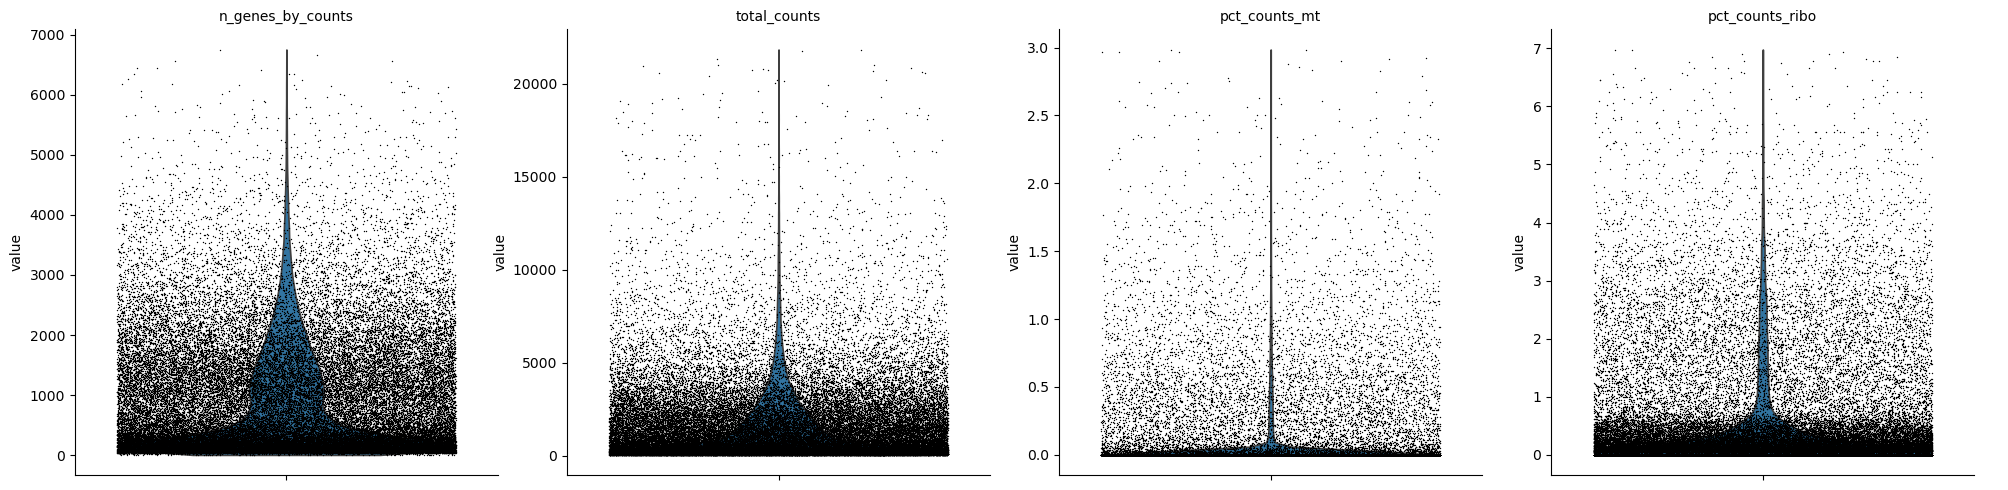

human


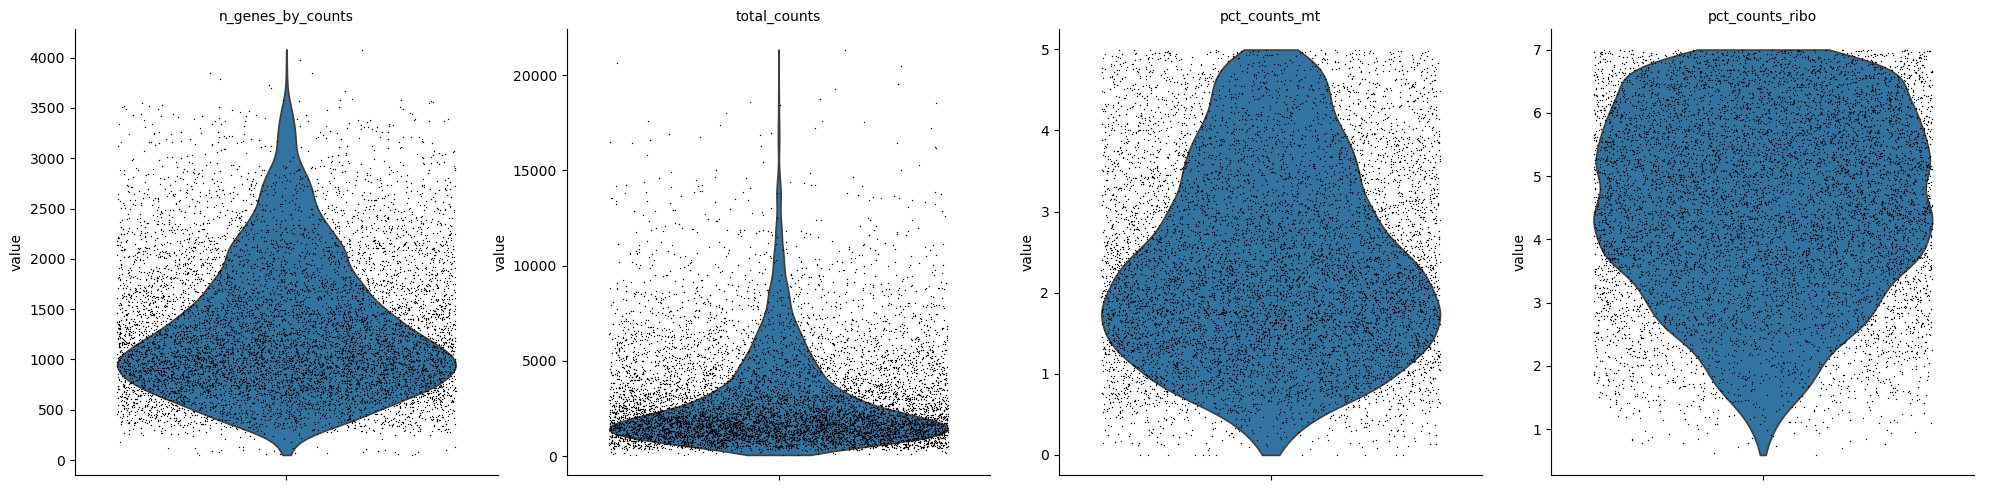

In [135]:
for adata in [mouse_data,human_data,nmr_data, dev_human]:
    print(adata.obs['species'][0])
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
        jitter=0.4,
        multi_panel=True,
    )

In [136]:
# Save a temporal copy just in case
mo = mouse_data.copy()
hu = human_data.copy()
nm = nmr_data.copy()
dh = dev_human.copy()


In [137]:
# Run to go back to this checkpoint
mouse_data,human_data,nmr_data, dev_human = (mo,hu,nm,dh)

## Subset each dataset.var by only shared genes by at least 2 species

In [138]:
# Find intersection of global_name across all datasets
mouse_genes = set(mouse_data.var['global_name'].dropna())
human_genes = set(human_data.var['global_name'].dropna())
nmr_genes = set(nmr_data.var['global_name'].dropna())

shared_genes = mouse_genes & human_genes & nmr_genes
print(f"Number of shared genes by global_name: {len(shared_genes)}")
print(f"Number of shared genes between human and nmr: {len(human_genes & nmr_genes)}")
print(f"Number of shared genes between mouse and human: {len(mouse_genes & human_genes)}")
print(f"Number of shared genes between mouse and nmr: {len(mouse_genes & nmr_genes)}")
any_shared_genes = (human_genes & nmr_genes) | (mouse_genes & nmr_genes)
print(f"Number of genes shared by at least two species: {len(any_shared_genes)}")


Number of shared genes by global_name: 7420
Number of shared genes between human and nmr: 8497
Number of shared genes between mouse and human: 7420
Number of shared genes between mouse and nmr: 8938
Number of genes shared by at least two species: 10015


In [139]:
# Subset each dataset to shared global_name genes
mouse_data_shared = mouse_data[:, mouse_data.var['global_name'].isin(any_shared_genes)]
human_data_shared = human_data[:, human_data.var['global_name'].isin(any_shared_genes)]
nmr_data_shared = nmr_data[:, nmr_data.var['global_name'].isin(any_shared_genes)]
dev_human_shared = dev_human[:, dev_human.var['global_name'].isin(any_shared_genes)]

In [140]:
# reorder columns to match
shared_genes_sorted = sorted(any_shared_genes)
mouse_data_shared = mouse_data_shared[:, mouse_data_shared.var['global_name'].isin(shared_genes_sorted)]
human_data_shared = human_data_shared[:, human_data_shared.var['global_name'].isin(shared_genes_sorted)]
nmr_data_shared = nmr_data_shared[:, nmr_data_shared.var['global_name'].isin(shared_genes_sorted)]
dev_human_shared = dev_human[:, dev_human.var['global_name'].isin(shared_genes_sorted)]

## Merge datasets from different species

- Correct var_names

- Delete duplicated gene names with lower counts

In [141]:
adata_list = [mouse_data_shared, human_data_shared, nmr_data_shared, dev_human_shared]
for i, ad in enumerate(adata_list):
    print(f"adata {i} var_names head:\n", ad.var_names[:10],'\n')


adata 0 var_names head:
 Index(['0610010K14Rik', '1110059G10Rik', '1600012H06Rik', '1600014C10Rik',
       '1700009N14Rik', '1700012B09Rik', '1700017N19Rik', '1700020A23Rik',
       '1700025G04Rik', '1700067K01Rik'],
      dtype='object') 

adata 1 var_names head:
 Index(['ENSG00000237330', 'ENSG00000131591', 'ENSG00000186891',
       'ENSG00000186827', 'ENSG00000078808', 'ENSG00000184163',
       'ENSG00000127054', 'ENSG00000107404', 'ENSG00000162576',
       'ENSG00000175756'],
      dtype='object', name='Accession') 

adata 2 var_names head:
 Index(['ZMYND10', 'NPRL2', 'GMPPB', 'NCEH1', 'PIK3CB', 'BDH1', 'KLHL40',
       'NCKIPSD', 'BTC', 'ECT2'],
      dtype='object') 

adata 3 var_names head:
 Index(['KLHL17', 'PLEKHN1', 'RNF223', 'C1orf159', 'TNFRSF18', 'TNFRSF4',
       'SDF4', 'C1QTNF12', 'PUSL1', 'INTS11'],
      dtype='object', name='global_name') 



In [142]:
# Setting global_name as var_names for each dataset
for ad in adata_list:
    if "global_name" in ad.var.columns:
        ad.var_names = ad.var["global_name"].astype(str)

In [143]:
# Now see how var_names ended up
for i, ad in enumerate(adata_list):
    print(f"adata {i} var_names head:\n", ad.var_names[:10],'\n')

adata 0 var_names head:
 Index(['C17orf49', 'KIAA1143', 'C6orf120', 'C19orf12', '1700009N14Rik',
       'C11orf97', 'C12orf50', '1700020A23Rik', 'C1orf21', 'C19orf67'],
      dtype='object', name='global_name') 

adata 1 var_names head:
 Index(['RNF223', 'C1orf159', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'C1QTNF12',
       'INTS11', 'DVL1', 'MXRA8', 'AURKAIP1'],
      dtype='object', name='global_name') 

adata 2 var_names head:
 Index(['ZMYND10', 'NPRL2', 'GMPPB', 'NCEH1', 'PIK3CB', 'BDH1', 'KLHL40',
       'NCKIPSD', 'BTC', 'ECT2'],
      dtype='object', name='global_name') 

adata 3 var_names head:
 Index(['KLHL17', 'PLEKHN1', 'RNF223', 'C1orf159', 'TNFRSF18', 'TNFRSF4',
       'SDF4', 'C1QTNF12', 'PUSL1', 'INTS11'],
      dtype='object', name='global_name') 



In [144]:
# Check for duplicated genes before merging
human_duplicates = human_data_shared.var['global_name'][human_data_shared.var['global_name'].duplicated()]
print('Human adult duplicates:',human_duplicates)

nmr_duplicates = nmr_data_shared.var['global_name'][nmr_data_shared.var['global_name'].duplicated()]
print('NMR duplicates:',nmr_duplicates)

mouse_duplicates = mouse_data_shared.var['global_name'][mouse_data_shared.var['global_name'].duplicated()]
print('Mouse duplicates:',mouse_duplicates)

dev_human_duplicates = dev_human_shared.var['global_name'][dev_human_shared.var['global_name'].duplicated()]
print('Developing Human duplicates:',dev_human_duplicates)

Human adult duplicates: Series([], Name: global_name, dtype: category
Categories (8497, object): ['1700034E13Rik', '2310022A10Rik', '4921524J17Rik', '6030468B19Rik', ..., 'Zmym3', 'Zmym5', 'Zpbp2', 'Zswim9'])
NMR duplicates: global_name
RPS3A    RPS3A
Name: global_name, dtype: category
Categories (10015, object): ['1700009N14Rik', '1700020A23Rik', '1700034E13Rik', '2310022A10Rik', ..., 'Zmym3', 'Zmym5', 'Zpbp2', 'Zswim9']
Mouse duplicates: Series([], Name: global_name, dtype: category
Categories (8938, object): ['1700009N14Rik', '1700020A23Rik', '2310022A10Rik', '2610028H24Rik', ..., 'Zmym2', 'Zmym3', 'Zmym5', 'Zpbp2'])
Developing Human duplicates: global_name
SHOX      SHOX
ASMTL    ASMTL
ASMT      ASMT
Name: global_name, dtype: category
Categories (8499, object): ['1700034E13Rik', '2310022A10Rik', '4921524J17Rik', '4933427D14Rik', ..., 'Zmym3', 'Zmym5', 'Zpbp2', 'Zswim9']


In [145]:
mouse_data_shared.var[mouse_data_shared.var['global_name'].isin(mouse_duplicates)]

,n_cells,global_name,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
global_name,,,,,,,,,,


In [146]:
human_data_shared.var[human_data_shared.var['global_name'].isin(human_duplicates.values)]

,Chromosome,End,Gene,Start,Strand,global_name,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
global_name,,,,,,,,,,,,,,


In [147]:
nmr_data_shared.var[nmr_data_shared.var['global_name'].isin(nmr_duplicates.values)]

,gene_ids,genome,feature_types,species,global_name,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
global_name,,,,,,,,,,,,,
RPS3A,ENSHGLG00000016233,NA,Gene Expression,nmr,RPS3A,False,True,9,0.000136,0.000136,99.98639,9.0,2.302585
RPS3A,ENSHGLG00000000392,NA,Gene Expression,nmr,RPS3A,False,False,954,0.015183,0.015069,98.55730,1004.0,6.912743


In [148]:
dev_human_shared.var[dev_human_shared.var['global_name'].isin(dev_human_duplicates.values)]


,Accession,Chromosome,End,GeneTotalUMIs,Start,Gene,mt,global_name,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
global_name,,,,,,,,,,,,,,,
SHOX,ENSG00000185960,chrX,659411,1564,624344,SHOX,False,SHOX,False,50,0.002552,0.002549,99.749762,51.0,3.951244
ASMTL,ENSG00000169093,chrX,1453762,3697,1403139,ASMTL,False,ASMTL,False,37,0.001852,0.001850,99.814824,37.0,3.637586
ASMT,ENSG00000196433,chrX,1643081,573,1615059,ASMT,False,ASMT,False,8,0.000450,0.000450,99.959962,9.0,2.302585
SHOX,ENSG00000185960,chrY,659411,1586,624344,SHOX-1,False,SHOX,False,45,0.002452,0.002449,99.774786,49.0,3.912023
ASMTL,ENSG00000169093,chrY,1453762,4548,1403139,ASMTL-1,False,ASMTL,False,54,0.002703,0.002699,99.729743,54.0,4.007333
ASMT,ENSG00000196433,chrY,1643081,594,1615059,ASMT-1,False,ASMT,False,3,0.000150,0.000150,99.984986,3.0,1.386294


In [149]:
from scipy import sparse

def drop_lower_count_duplicates(adata, gene_key="global_name", verbose=True):
    """
    Remove duplicated genes by keeping the one with highest global expression.
    Prints info about duplicates if verbose=True.
    
    Parameters
    ----------
    adata : AnnData
    gene_key : str
        Column in `adata.var` to identify gene names (default "global_name").
    verbose : bool
        If True, print duplicate genes and their counts.
    
    Returns
    -------
    AnnData with unique genes
    """
    # Get gene names
    if gene_key in adata.var.columns:
        genes = adata.var[gene_key].astype(str)
    else:
        genes = adata.var_names.astype(str)

    # Compute total counts per gene (sparse-aware)
    if sparse.issparse(adata.X):
        total_counts = np.array(adata.X.sum(axis=0)).flatten()
    else:
        total_counts = adata.X.sum(axis=0)

    # Build dataframe
    df = pd.DataFrame({
        "gene": genes.values,
        "total_counts": total_counts,
        "idx": np.arange(len(genes))
    })

    # Find duplicates
    dupes = df[df.duplicated("gene", keep=False)].sort_values("gene")

    if verbose and not dupes.empty:
        print("\nDuplicate genes found:")
        for g, sub in dupes.groupby("gene"):
            print(f"  {g}:")
            for _, row in sub.iterrows():
                print(f"    idx={row['idx']} total_counts={row['total_counts']}")
    
    # Keep max count per gene
    keep_idx = df.loc[df.groupby("gene")["total_counts"].idxmax(), "idx"].values

    # Subset AnnData
    adata_unique = adata[:, keep_idx].copy()
    adata_unique.var_names = genes.iloc[keep_idx].values

    return adata_unique


In [150]:
mouse_clean = drop_lower_count_duplicates(mouse_data_shared, gene_key="global_name")

print("Before:", mouse_data_shared.shape)
print("After:", mouse_clean.shape)

Before: (14181, 8938)
After: (14181, 8938)


In [151]:
human_clean = drop_lower_count_duplicates(human_data_shared, gene_key="global_name")

print("Before:", human_data_shared.shape)
print("After:", human_clean.shape)

Before: (48406, 8497)
After: (48406, 8497)


In [152]:
nmr_clean = drop_lower_count_duplicates(nmr_data_shared, gene_key="global_name")
print("Before:", nmr_data_shared.shape)
print("After:", nmr_clean.shape)


Duplicate genes found:
  RPS3A:
    idx=820 total_counts=9.0
    idx=8624 total_counts=964.0
Before: (57171, 10016)
After: (57171, 10015)


In [153]:
dev_human_clean = drop_lower_count_duplicates(dev_human_shared, gene_key="global_name")

print("Before:", dev_human_shared.shape)
print("After:", dev_human_clean.shape)


Duplicate genes found:
  ASMT:
    idx=8254 total_counts=7.0
    idx=8493 total_counts=3.0
  ASMTL:
    idx=8253 total_counts=17.0
    idx=8492 total_counts=22.0
  SHOX:
    idx=8252 total_counts=38.0
    idx=8491 total_counts=39.0
Before: (8703, 8502)
After: (8703, 8499)


In [154]:
outer_merged = sc.concat(
    [mouse_clean, nmr_clean, human_clean, dev_human_clean],
    join="outer", 
    merge="same",
    label="dataset_name",
    keys=["mouse", "nmr", "human", "human_dev"],
    fill_value=0
)

print("Merged AnnData (outer):", outer_merged.shape)

Merged AnnData (outer): (128461, 10015)


In [155]:
outer_merged.obs['dataset_name'].value_counts()

dataset_name
nmr          57171
human        48406
mouse        14181
human_dev     8703
Name: count, dtype: int64

In [156]:
## CHECKPOINT
filename = f'/home/raquelcr/scanpy/all_adata_outer{rev_n}.h5ad'
outer_merged.write_h5ad(filename)
print(f"AnnData object successfully saved to {filename}")

AnnData object successfully saved to /home/raquelcr/scanpy/all_adata_outer7.h5ad


In [157]:
#outer_merged = sc.read(filename)

In [158]:
outer_merged.obs

,label,sizeFactor,subclass,n_counts,species,cell_type,cell_supertype,dissection,region,n_genes_by_counts,...,Region,Subregion,tissue_type,tissue_ontology_term_id,cell_type_ontology_term_id,fraction_mitochondrial,fraction_unspliced,cell_cycle_score,total_genes,dataset_name
F1S4_160108_001_A01,Vip,1.085313,Vip,1730700.0,mouse,CGE_276,CGE interneuron,Visual Cortex,cerebral cortex,9029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mouse
F1S4_160108_001_B01,Lamp5,1.197503,Lamp5,1909605.0,mouse,CGE_277,CGE interneuron,Visual Cortex,cerebral cortex,10207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mouse
F1S4_160108_001_C01,Lamp5,1.244751,Lamp5,1984948.0,mouse,CGE_277,CGE interneuron,Visual Cortex,cerebral cortex,10578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mouse
F1S4_160108_001_D01,Vip,1.437020,Vip,2291552.0,mouse,CGE_276,CGE interneuron,Visual Cortex,cerebral cortex,8482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mouse
F1S4_160108_001_E01,Lamp5,1.102096,Lamp5,1757463.0,mouse,CGE_277,CGE interneuron,Visual Cortex,cerebral cortex,8697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mouse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X122_8:GTCATTTAGGAGTTTA,NaN,NaN,NaN,NaN,human,Bgl_51,Bergmann glia,Mesencephalon,midbrain,1402,...,Midbrain,Midbrain,tissue,UBERON:0001891,CL:0000681,0.004478,0.271384,0.021346,3268,human_dev
10X122_8:CGTCTACTCAGCAACT,NaN,NaN,NaN,NaN,human,Bgl_51,Bergmann glia,Mesencephalon,midbrain,883,...,Midbrain,Midbrain,tissue,UBERON:0001891,CL:0000681,0.007848,0.208800,0.029148,2054,human_dev
10X122_7:AGAGCGATCGGCGCAT,NaN,NaN,NaN,NaN,human,Bgl_51,Bergmann glia,Mesencephalon,midbrain,994,...,Midbrain,Midbrain,tissue,UBERON:0001891,CL:0000681,0.011569,0.223045,0.020130,2340,human_dev
10X122_8:TTATGCTAGAGCCCAA,NaN,NaN,NaN,NaN,human,Bgl_51,Bergmann glia,Mesencephalon,midbrain,848,...,Midbrain,Midbrain,tissue,UBERON:0001891,CL:0000681,0.015557,0.323273,0.018357,1993,human_dev
